![Rossmann](rossmann_mark.jpg)

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation.    


## Metadata description
---
Columns       | Descriptions 
--------------|-------
Id|An Id that represents a (Store, Date) duple within the test set
Store|A unique Id for each store
Sales|The turnover on a given day (our target variable)
Customers|The number of customers on a given day
Open|open: 0 = the store is closed , 1 = the store is open
StateHoliday|Indicates a state holiday. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
SchoolHoliday|Store on this Date was affected or not by the closure of public schools
StoreType|4 different stores:a,b,c,d
Assortment|Assortment level: a = basic, b = extra, c = extended
CompetitionDistance|Distance in meters to the nearest competitor store
CompetitionOpenSince[Month/Year]|gives the approximate year and month of the time the nearest competitor was opened
Promo|Promo or not on that day
Promo2|Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
Promo2Since[Year/Week]|describes the year and calendar week when the store started participating in Promo2
PromoInterval|describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


## What kind of problem to solve?

Regression or time series problem, here we propose regression method with embedding features tech to catch the data information

In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys, numpy as np, pandas as pd, tensorflow as tf, re, codecs, json, time
import pickle, collections, random, math, numbers, scipy.sparse as sp, itertools, shutil
import requests, seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
from pprint import pprint
from matplotlib import pyplot as plt
# plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid') # 

ctx = os.path.abspath(os.path.dirname('.'))
if ctx not in sys.path:
    sys.path.insert(0, ctx)

from trainer import utils
from trainer import app_conf, metadata, input as inp, service
from trainer.ctrl import Ctrl

np.set_printoptions(precision=4, suppress=True, linewidth=100)
np.warnings.filterwarnings('ignore')

init logger instance ...


## Preview

In [86]:
tr = pd.read_csv('./data/train.csv')
store = pd.read_csv('./data/store.csv')
store_states = pd.read_csv('./data/store_states.csv')

In [24]:
tr.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [25]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9,2008,0,NaN,NaN,NaN
1,2,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9,2009,0,NaN,NaN,NaN
4,5,a,a,29910.0,4,2015,0,NaN,NaN,NaN


In [26]:
store_states.head()

,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


In [2]:
%%time
Ctrl.instance.input.clean('./data/train.csv')

2018-07-31 19:18:57,103 - trainer.input - INFO [line:22] - Clean start, is_serving: False
2018-07-31 19:19:02,091 - trainer.input - INFO [line:51] - Clean take time 0:00:04.987285
Wall time: 5.01 s


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday
0,1,5,2015-07-31,5263.0,555.0,1,1,0,1
1,2,5,2015-07-31,6064.0,625.0,1,1,0,1
2,3,5,2015-07-31,8314.0,821.0,1,1,0,1
3,4,5,2015-07-31,13995.0,1498.0,1,1,0,1
4,5,5,2015-07-31,4822.0,559.0,1,1,0,1
5,6,5,2015-07-31,5651.0,589.0,1,1,0,1
6,7,5,2015-07-31,15344.0,1414.0,1,1,0,1
7,8,5,2015-07-31,8492.0,833.0,1,1,0,1
8,9,5,2015-07-31,8565.0,687.0,1,1,0,1
9,10,5,2015-07-31,7185.0,681.0,1,1,0,1


In [27]:
%%time
merge = Ctrl.instance.input.prepare('./data/processed/cleaned/tr.csv', is_serving=False)

2018-07-31 19:36:19,483 - trainer.input - INFO [line:55] - Prepare start, is_serving: False
2018-07-31 19:36:20,222 - trainer.input - INFO [line:93] - Persisten store to H:\workspace\notebook\ml-specialized\rossmann/data/processed/prepared/store.csv
2018-07-31 19:37:00,555 - trainer.input - INFO [line:137] - Prepare take time 0:00:41.071349
Wall time: 41.1 s


In [29]:
%%time
Ctrl.instance.input.fit(merge)

2018-07-31 19:37:19,621 - trainer.input - INFO [line:149] - sales_mean.mean: 5790.497727770823, sales_mean.stdv: 2082.5033707220155, sales_mean.median: 5471.351380042463
2018-07-31 19:37:19,684 - trainer.input - INFO [line:149] - competition_open_since.mean: 14424.153547512962, competition_open_since.stdv: 1805.9849602002341, competition_open_since.median: 14641.0
2018-07-31 19:37:19,748 - trainer.input - INFO [line:149] - promo2since.mean: 15295.40708578792, promo2since.stdv: 430.7254916875331, promo2since.median: 15340.0
2018-07-31 19:37:19,819 - trainer.input - INFO [line:149] - competition_distance.mean: 5450.044851706307, competition_distance.stdv: 7801.082007118503, competition_distance.median: 2325.0
2018-07-31 19:37:19,893 - trainer.input - INFO [line:149] - competition_open_since.mean: 14424.153547512962, competition_open_since.stdv: 1805.9849602002341, competition_open_since.median: 14641.0
2018-07-31 19:37:19,963 - trainer.input - INFO [line:149] - promo2since.mean: 15295.40

In [32]:
%%time
merge = Ctrl.instance.input.transform('./data/processed/prepared/tr.csv')
Ctrl.instance.input.split(merge)

2018-07-31 19:43:28,787 - trainer.input - INFO [line:169] - Prepare start, is_serving: False
2018-07-31 19:43:30,596 - trainer.input - INFO [line:177] - Do np.log(data.sales) !
2018-07-31 19:43:30,614 - trainer.input - INFO [line:184] - Transform take time 0:00:01.826104
2018-07-31 19:43:30,616 - trainer.input - INFO [line:193] - Split start
2018-07-31 19:43:45,107 - trainer.input - INFO [line:217] - Split take time 0:00:14.490829
Wall time: 16.4 s


## Data Exploration
- First we add some columns `year, month, day, promo2, sales_mean, customers_mean, competition_open_since, promo2since`
    - We treat `year, month, day` as categorical variables, we expect there are maybe some peak hour or off peak time on specific date, continuous variables couldn't handle this well.
    - `Promo2` is a continuing and consecutive promotion campaign, which have periodicity per year, it can calculate according to store.Promo2 and store.PromoInterval columns.
    - Both `sales_mean` and `customers_mean` columns are average of sales and customers per store, they can well catch the quantity respectively
    - `competition_open_since` 是附近競爭者出現的最初時間, 該時間減去1970/01/01的天數
    - `promo2since` 是開始週期性promotion的最初時間, 該時間減去1970/01/01的天數

In [69]:
%%time
store['CompetitionDistance'] = store.CompetitionDistance.fillna(store.CompetitionDistance.median())
# Add columns `CompetitionOpenSince`, according to date `CompetitionOpenSinceYear` + `CompetitionOpenSinceMonth`,
# to calcucate scaler from 1970/01/01 to which
def map_fn(e):
    y, m = e
    if pd.isna(y) or pd.isna(m): return np.nan
    # y, m = int(float(y)), int(float(m))
    return f'{y}-{m}-1'
since_dt = pd.Series(list(zip(store.CompetitionOpenSinceYear, store.CompetitionOpenSinceMonth)))\
             .map(map_fn, na_action='ignore')
store['competition_open_since'] = (pd.to_datetime(since_dt) - datetime(1970, 1, 1)).dt.days
store['competition_open_since'].fillna(store['competition_open_since'].median(), inplace=True)
# Add columns `Promo2Since`, according to date `Promo2SinceYear` + `Promo2SinceWeek`,
# to calcucate scaler from 1970/01/01 to which
def promo2_fn(e):
    y, week = e
    if pd.isna(y) or pd.isna(week): 
        return np.nan
    return (datetime.strptime(f'{y}', '%Y') + timedelta(weeks=int(week)) - datetime(1970, 1, 1)).days
store['promo2since'] = pd.Series(list(zip(store.Promo2SinceYear, store.Promo2SinceWeek))).map(promo2_fn)
store['promo2since'].fillna(store['promo2since'].median(), inplace=True)
# Alter datatype and fill NaN value to 0
for col in ('CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear'):
    tr_merge[col] = tr_merge[col].map(int, na_action='ignore').fillna(0)

tr_merge = tr.merge(store, how='left', on='Store').merge(store_states, how='left', on='Store')
tr_merge['StateHoliday'] = tr_merge.StateHoliday.map(str)
# tr_merge['PerCustomerSales'] = tr_merge.Sales / tr_merge.Customers

# Construct year, month, day columns, maybe on sepicific day or period will has some trends.
dt = pd.to_datetime(tr_merge.Date)
tr_merge['year'] = dt.dt.year
tr_merge['month'] = dt.dt.month
tr_merge['day'] = dt.dt.day

# Promo2 is a continuing and consecutive promotion campaign, which have periodicity per year
# it can calculate according to store.Promo2 and store.PromoInterval columns
tr_merge['promo2'] = Ctrl.instance.input.cal_promo2(tr_merge)

# Construct customers mean and sales mean columns, at least we know whether this store is popular
tr_merge['sales_mean'] = tr_merge.groupby('Store').Sales.mean().reindex(tr_merge.Store).values
tr_merge['customers_mean'] = tr_merge.groupby('Store').Customers.mean().reindex(tr_merge.Store).values
tr_merge.head()

Wall time: 33.5 s


## Filter some rows
We found that on store close day of course sales equals to 0, so drop the `open = 0`

Promo
0    2.771974e+09
1    3.101206e+09
Name: Sales, dtype: float64


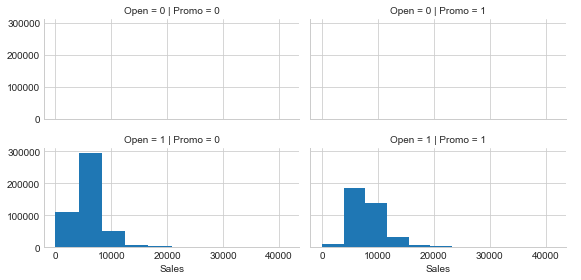

In [70]:
print(tr_merge.groupby('Promo').Sales.sum())
g = sns.FacetGrid(tr_merge, row='Open', col='Promo', size=2, aspect=2)
g = g.map(plt.hist, "Sales").add_legend()

In [71]:
# Remove Open != 1, because Sales = 0
tr_merge = tr_merge.query('Open == 1')

# a = tr_merge.groupby(['Store', 'Promo', 'StateHoliday', 'SchoolHoliday']).agg({
#     'Sales': sum, 'Customers': sum, 'Open': sum,
#     # 'StoreType': max, 'Assortment': max, 'State': max
# }).reset_index()
# a.head(20)

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

## Pearson Correlation
- Observe whether there are continuous columns have linear relation with target column `sales`

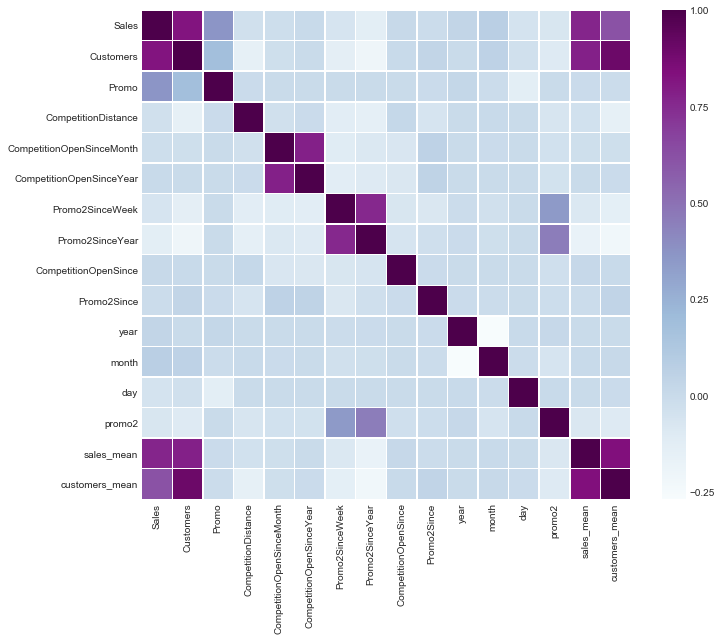

In [73]:
# plt.figure(figsize=(6, 4))
# sns.heatmap(tr_merge[['sales_mean', 'customers_mean', 'Customers', 'Sales']].corr(), annot=True)
# plt.show()

corr_all = tr_merge.drop(['Open', 'Promo2'], 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

1. `Customers` have siginificant positive correlation, `sales_mean`本身就是`Sales`衍伸出來的欄位, 當然會Significant, 
而跟`Sales`高相關的`Customers`衍生的`customs_mean`理所當然高相關
2. 很可惜的是, 新增的欄位 `competition_open_since`, `promo2since` 都沒有和`Sales`有任何線性關係, 但我們仍然會將他放入Training
<br/>
<br/>

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
## Univariate Analysis
- Observe some categorical variables, see if there is some sigificant relation
- In this section:
    - Significant:
        - `Promo`: the sales raise in promo perieod.
        - `DayOfWeek`: When DayOfWeek = 7, it obviously people count less than average
        - `StoreType`: StoreType = 'b' has the lowest counts and the highest average
    - Not significant:
        - `Promo2`: Nothing found!

## Target Column: Sales

In [20]:
# Some misc drawing setting
meanprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')

In [18]:
df = pd.DataFrame({'Sales': tr_merge.Sales.tolist() + np.log1p(tr_merge.Sales).tolist(), 
                   'clazz': ['Origin'] * len(tr_merge) + ['After np.log1p'] * len(tr_merge)})
print(df.query("clazz == 'Origin'").Sales.describe())

count    844392.000000
mean       6955.514291
std        3104.214680
min           0.000000
25%        4859.000000
50%        6369.000000
75%        8360.000000
max       41551.000000
Name: Sales, dtype: float64


<br/>
Observe the the describe table and boxplot of target, the mean is about 6955, so we need to take logrithm in order to reduce scale

count    844392.000000
mean          8.757177
std           0.430917
min           0.000000
25%           8.488794
50%           8.759355
75%           9.031333
max          10.634701
Name: Sales, dtype: float64


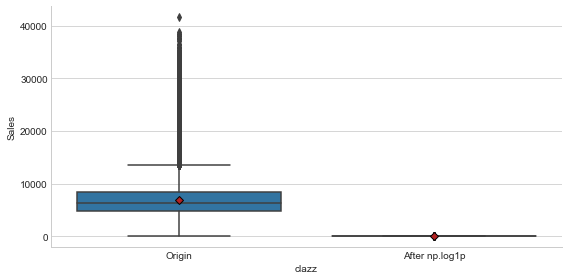

In [22]:
print(df.query("clazz == 'After np.log1p'").Sales.describe())
sns.catplot(x='clazz', y='Sales', data=df, kind="box", height=4, aspect=2, sharey=False, showmeans=True, meanprops=meanprops)
plt.show()

Scale較大的時候通常會取log, 使得machine在training的時候較容易收斂, Sales取log後value落在 0 ~ 10 之間
<br/>
<br/>
<br/>

## Promo: 看看promotion時期和平常時期的比較

Promo
0    2771974337
1    3101206286
Name: Sales, dtype: int64


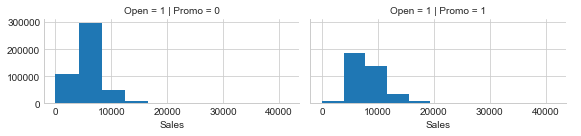

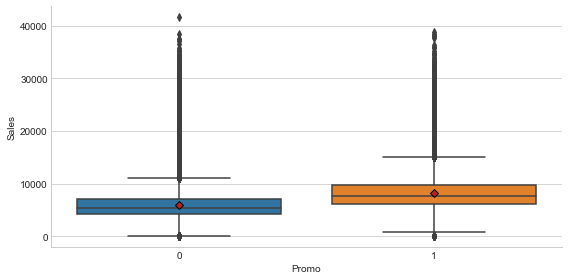

In [23]:
# plt.figure(figsize=(12, 6))
print(tr_merge.groupby('Promo').Sales.sum())
g = sns.FacetGrid(tr_merge, row='Open', col='Promo', height=2, aspect=2)
g = g.map(plt.hist, "Sales").add_legend()

sns.catplot(x="Promo", y="Sales", data=tr_merge, kind="box", height=4, aspect=2, showmeans=True, meanprops=meanprops)

In [24]:
agg = tr_merge.groupby(['Promo']).Sales.describe()
agg['sum'] = agg['count'] * agg['mean']
agg

,count,mean,std,min,25%,50%,75%,max,sum
Promo,,,,,,,,,
0,467496.0,5929.407603,2629.648385,0.0,4242.0,5459.0,7004.0,41551.0,2.771974e+09
1,376896.0,8228.281239,3175.759157,0.0,6069.0,7649.0,9686.0,38722.0,3.101206e+09


可想而知有promotion的期間大家的人均消費增高, 來客數也增多
<br/>
<br/>
<br/>

## Promo2

promo2
0    4930376023
1     942804600
Name: Sales, dtype: int64


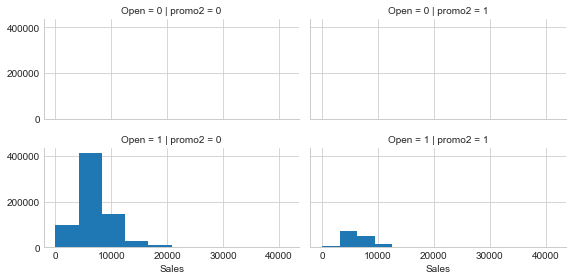

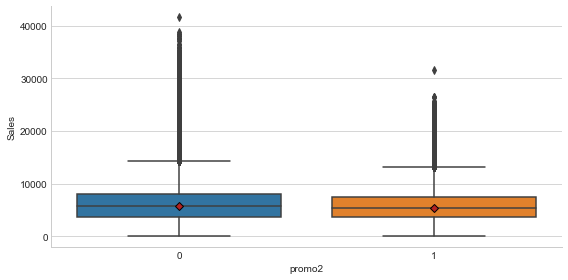

In [217]:
# plt.figure(figsize=(12, 6))
print(tr_merge.groupby('promo2').Sales.sum())
g = sns.FacetGrid(tr_merge, row='Open', col='promo2', height=2, aspect=2)
g = g.map(plt.hist, "Sales").add_legend()

sns.catplot(x="promo2", y="Sales", data=tr_merge, kind="box", height=4, aspect=2, showmeans=True, meanprops=meanprops)

In [25]:
agg = tr_merge.groupby(['promo2']).Sales.describe()
agg['sum'] = agg['count'] * agg['mean']
agg

,count,mean,std,min,25%,50%,75%,max,sum
promo2,,,,,,,,,
0,699164.0,7051.816202,3185.964977,0.0,4908.0,6440.0,8476.0,41551.0,4.930376e+09
1,145228.0,6491.892748,2626.976161,0.0,4650.0,6044.0,7837.0,31523.0,9.428046e+08


### DayOfWeek

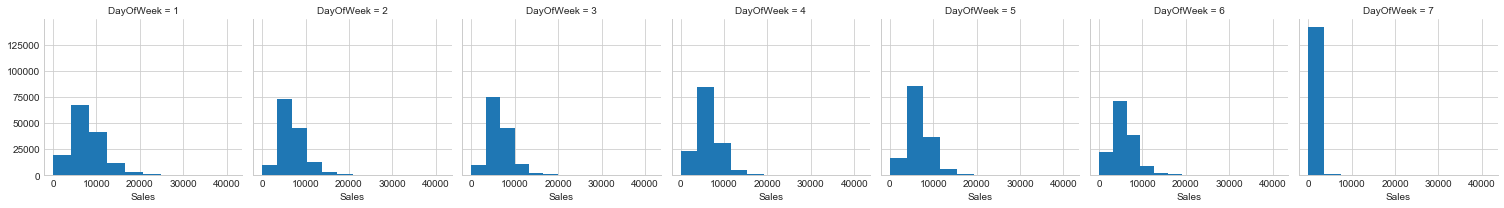

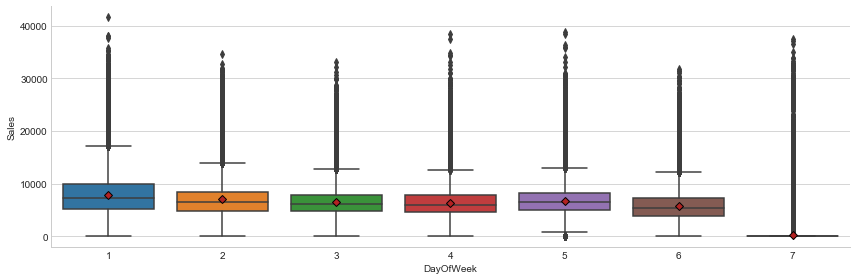

In [212]:
# plt.figure(figsize=(12, 6))
g = sns.FacetGrid(tr_merge, col='DayOfWeek', sharey=True, height=3, aspect=1)
g = g.map(plt.hist, "Sales")

sns.catplot(x="DayOfWeek", y="Sales", data=tr_merge, kind="box", height=4, aspect=3, showmeans=True, meanprops=meanprops)

In [29]:
agg = tr_merge.groupby('DayOfWeek').Sales.describe()
agg['sum'] = agg['count'] * agg['mean']
agg

,count,mean,std,min,25%,50%,75%,max,sum
DayOfWeek,,,,,,,,,
1,137560.0,8216.073074,3691.768876,0.0,5538.0,7539.0,10133.0,41551.0,1.130203e+09
2,143961.0,7088.113656,3066.237110,0.0,4960.0,6502.0,8521.0,34692.0,1.020412e+09
3,141936.0,6728.122978,2781.775174,0.0,4829.0,6210.0,7987.0,33151.0,9.549629e+08
4,134644.0,6767.310159,2764.548119,0.0,4900.0,6246.0,7987.0,38367.0,9.111777e+08
5,138640.0,7072.677012,2764.915744,0.0,5205.0,6580.0,8324.0,38722.0,9.805559e+08
6,144058.0,5874.840238,2852.730426,0.0,3925.0,5425.0,7232.0,31683.0,8.463177e+08
7,3593.0,8224.723908,6235.152960,286.0,3314.0,6876.0,11418.0,37376.0,2.955143e+07


## StoreType

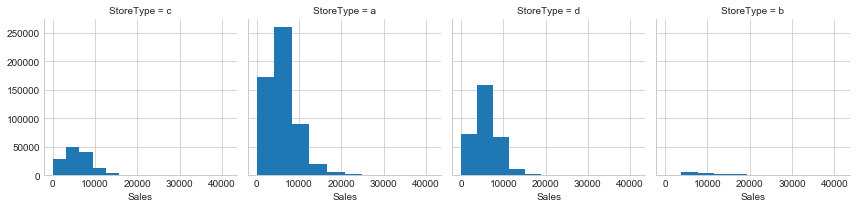

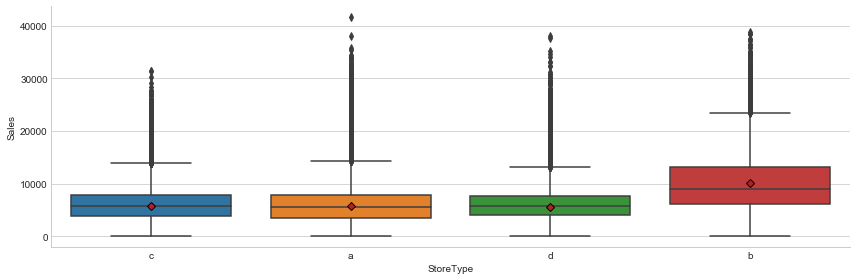

In [213]:
g = sns.FacetGrid(tr_merge, col='StoreType', sharey=True, height=3, aspect=1)
g = g.map(plt.hist, "Sales")

sns.catplot(x="StoreType", y="Sales", data=tr_merge, kind="box", height=4, aspect=3, showmeans=True, meanprops=meanprops)

In [73]:
agg = tr_merge.groupby('StoreType').Sales.describe()
agg['sum'] = agg['count'] * agg['mean']
agg

,count,mean,std,min,25%,50%,75%,max,sum
StoreType,,,,,,,,,
a,457077.0,6925.167661,3277.786381,0.0,4695.0,6285.0,8406.0,41551.0,3.165335e+09
b,15563.0,10231.407505,5157.190155,0.0,6344.0,9130.0,13183.5,38722.0,1.592314e+08
c,112978.0,6932.512755,2897.564578,0.0,4915.0,6407.0,8349.0,31448.0,7.832214e+08
d,258774.0,6822.141881,2556.582881,0.0,5050.0,6395.0,8123.0,38037.0,1.765393e+09


<br/>
<br/>
<br/>
<br/>
<br/>
## Bivariate Analysis
- In this section:
    - Significant:
        - `Promo + StateHoliday`: In mean heatmap figure, there is a peak on StateHoliday = 'b'
        - `State + StoreType`: When StoreType = 'b', the average of sales are unstable, and many States don't have StoreType 'b'
        
    - Not significant:
        - `Promo + SchoolHoliday`: Just found sum of the records with SchoolHoliday = 1 are less
        - `month + day`: In count heatmap, obviously records count(customers count) before july are upper than average, but we founds many store loss records in late date of timeline, that's why
        - `year + month`: Some peak in mean heatmap in December, corresponding to mean heatmap of [month + day], not really significant

In [229]:
def heatmap(*cols, annot=True, label='Sales'):
    # cols = ['Promo', 'SchoolHoliday']
    pivot_params = list(cols) + [label]
    g = tr_merge.groupby(list(cols))[label]
    mean_ = g.mean().reset_index().pivot(*pivot_params)
    count_ = g.size().reset_index().pivot(*pivot_params)
    sum_ = g.sum().reset_index().pivot(*pivot_params)

    f, axs = plt.subplots(1, 3, figsize=(16, 4))
    sns.heatmap(mean_, annot=annot, ax=axs[0])
    sns.heatmap(count_, annot=annot, ax=axs[1])
    sns.heatmap(sum_, annot=annot, ax=axs[2])
    axs[0].set_title(f'mean')
    axs[1].set_title(f'count')
    axs[2].set_title(f'sum')
    plt.show()

### Promo, SchoolHoliday 

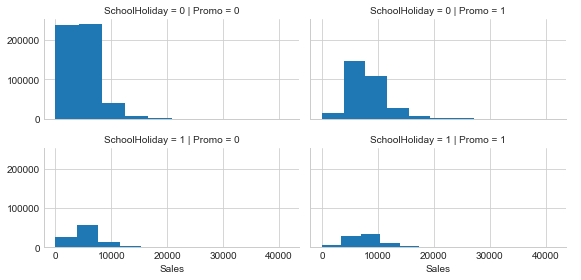

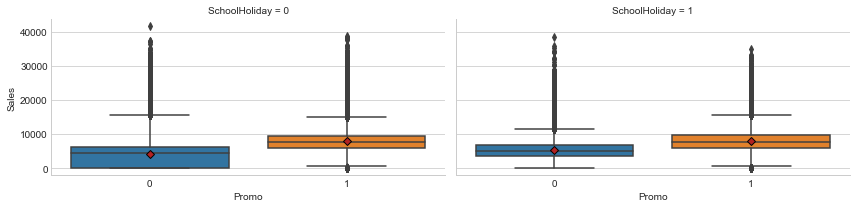

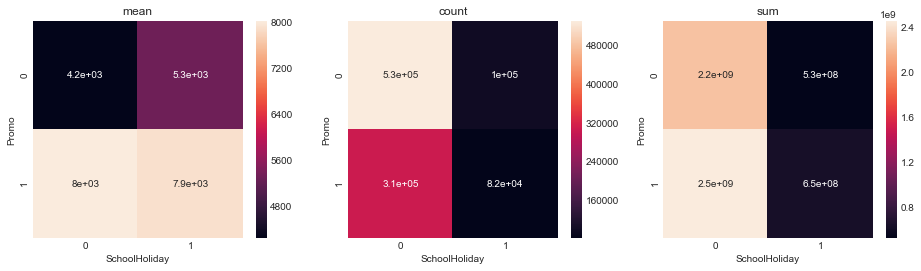

In [216]:
# print(tr_merge.groupby(['Store', 'SchoolHoliday', 'Promo']).Sales.sum())
g = sns.FacetGrid(tr_merge, row='SchoolHoliday', col='Promo', height=2, aspect=2)
g = g.map(plt.hist, "Sales").add_legend()

sns.catplot(x="Promo", y="Sales", col='SchoolHoliday', data=tr_merge, kind="box", height=3, aspect=2, showmeans=True, meanprops=meanprops)

heatmap('Promo', 'SchoolHoliday')

### Promo, StateHoliday 

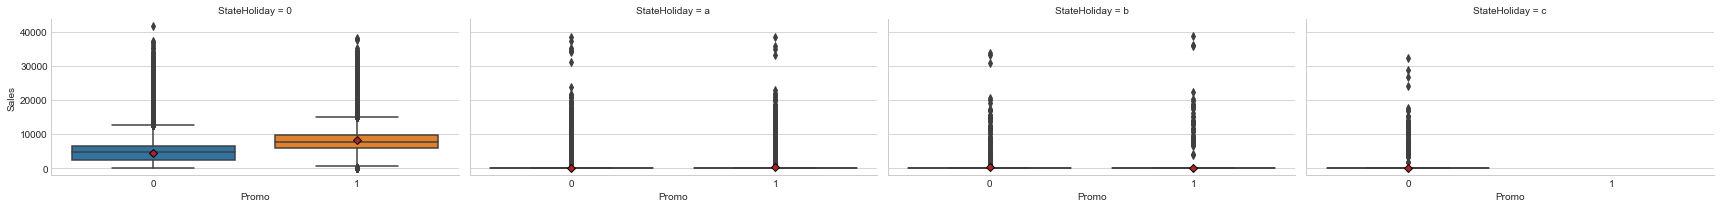

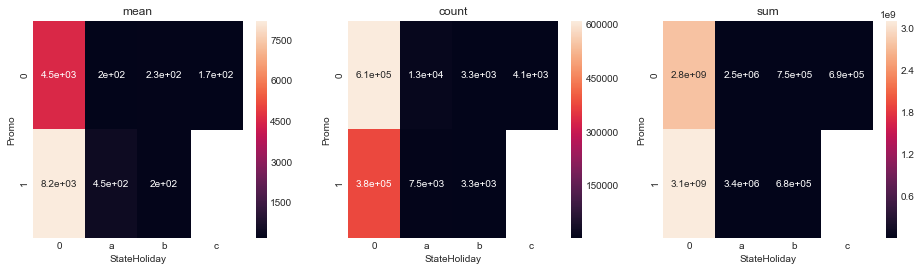

In [215]:
# g = sns.FacetGrid(tr_merge, row='StateHoliday', col='Promo', size=2, aspect=2)
# g = g.map(plt.hist, "Sales").add_legend()

sns.catplot(x="Promo", y="Sales", col='StateHoliday', data=tr_merge, kind="box", height=3, aspect=2, showmeans=True, meanprops=meanprops)
heatmap('Promo', 'StateHoliday')

### State, StoreType

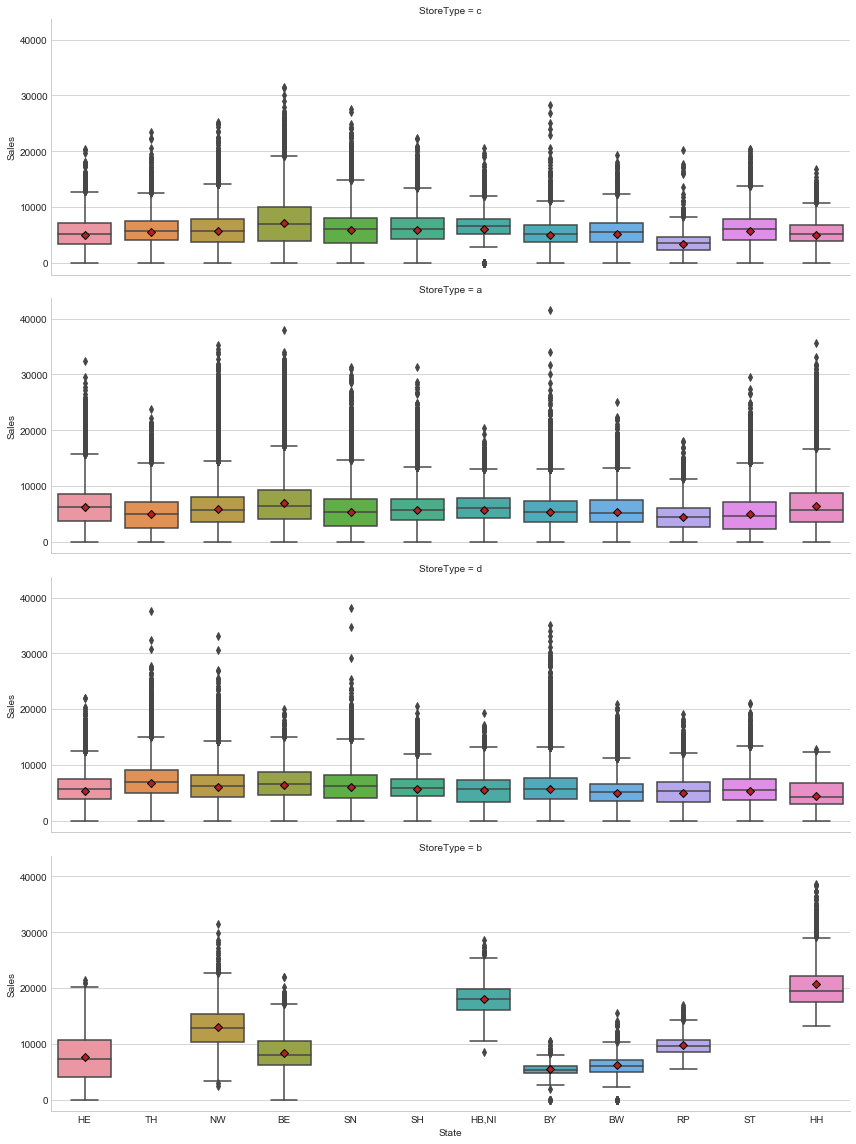

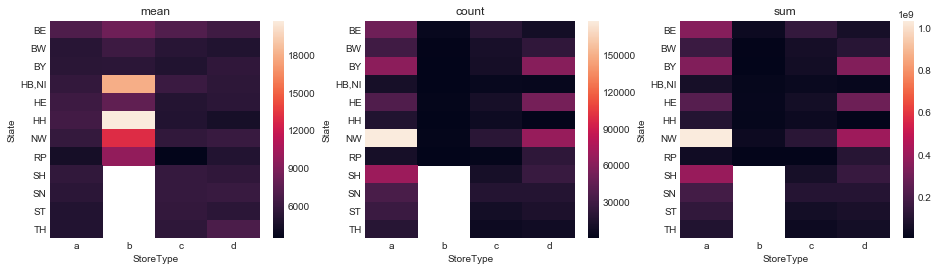

In [218]:
# g = sns.FacetGrid(tr_merge, col='State', row='StoreType', sharey=True, size=4, aspect=.5)
# g = g.map(plt.hist, "Sales")
meanprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
sns.catplot(x="State", y="Sales", row='StoreType', data=tr_merge, kind="box", 
               height=4, aspect=3, showmeans=True, meanprops=meanprops)

heatmap('State', 'StoreType', annot=False)

### Month, Day的熱點圖
1. 七月以後的Count人數較少, 但是Train Data裡每間商店最多只到2015-07-31, 這只是純粹最後一年少了8月初以後的資訊
2. Mean的部分, 並沒有任何的趨勢出現(除了15號的Sales量有增加, 但那很可能是某個Event造成)

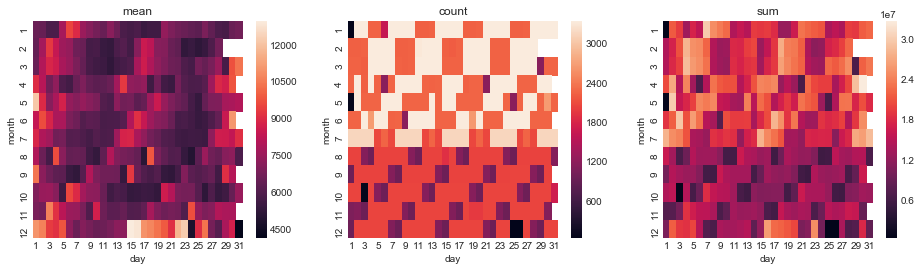

In [36]:
# sns.factorplot(x="day", y="Sales", row='month', data=tr_merge, kind="box", size=4, aspect=3)
heatmap('month', 'day', annot=False)

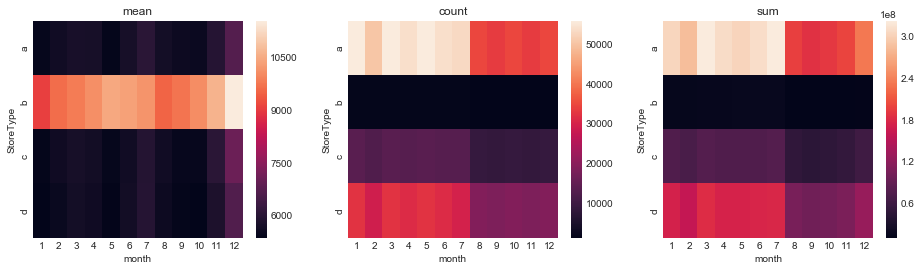

In [232]:
heatmap('StoreType', 'month', annot=False)

<br/>
<br/>
<br/>
## 三個變數以上的觀察
1. 因為類別數量少, 像 `DayOfWeek`, `StoreType`, `month`, `Promo` 等皆可Visualize觀察

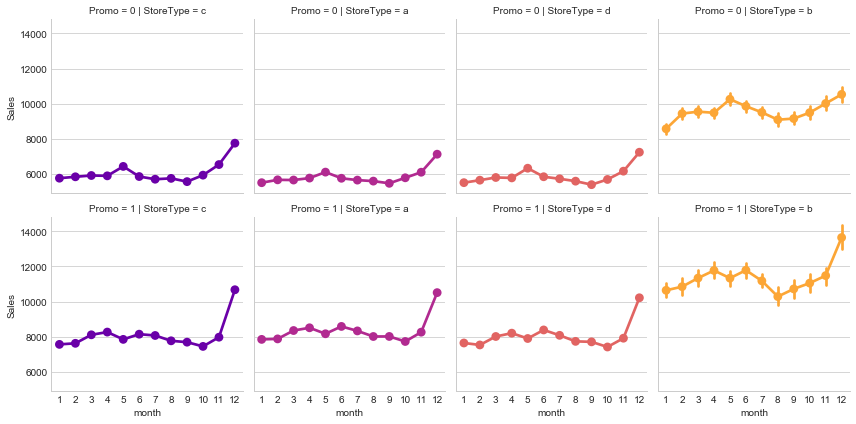

In [78]:
# sales trends# sales  
sns.catplot(data = tr_merge, x = 'month', y = "Sales", kind='point', height=3,
               col = 'StoreType', 
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')
plt.show()

<Figure size 432x288 with 0 Axes>

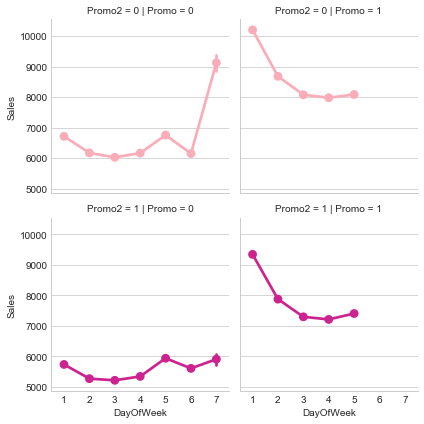

In [74]:
plt.figure(figsize=(6, 4))
sns.catplot(data = tr_merge, x = 'DayOfWeek', y = "Sales", kind='point', height=3,
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu')
plt.show()

<br/>
<br/>
<br/>
## Recall The Exploration
There are many combination of columns we didn't see, to view all the combination is not efficient, that's why we use embedding to encode the categorical variables, in Tensorflow, `tf.feature_columns.crossed_column` can help us to make machine learn the information hidden in data, or handle all the combination by yourself, but imagine that we couldn't expect all the crossed combination happend in training data, if some outlier happened in serving time, the performance usually bad as expected.
<br/><br/>
Fortunately, without using crossed features we still got good performance, and we drop `year` columns as the same reason we mentioned, future year not show in training data result in the bad performance happended (Remember we treat year as categorical variable), month and day features  show periodically

## Module structure
    ```
    └─trainer
        │  app_conf.py
        │  ctrl.py
        │  input.py
        │  logging.yaml
        │  metadata.py
        │  model.py
        │  service.py
        └─ utils.py        
    ```
    Directory trainer contains all modules: 
    
|File Name| Purpose| Do You Need to Change?
|:---|:---|:---
|[app_conf.py](trainer/app_conf.py) | Applicaiton configures, tell where are the training data, the model checkpoint directory, and hyperparameter | **Yes**, any params you don't want to pass in ctrl.py, you can put them here, but still, like the path to train directory, it's suggested to put app_conf.py instead of pass on the fly to controller.
|[ctrl.py](trainer/ctrl.py) |The entrance of the program, accept any parameters, protable for local terminal or restful style environment. | **Maybe**, althought the processing is constructed, some of detail you might wont to modify.
|[service.py](trainer/service.py) |The business logic module behind the controller(ctrl.py) | **Yes**, usually you still have your own programe process
|[utils.py](trainer/service.py) | Utility module, some common function to put here, like logging function. | **Yes**, maybe you will have some special utils function to implement.
|[metadata.py](trainer/metadata.py)|Defines: 1) task type, 2) input data header, 3) numeric and categorical feature names, 4) target feature name (and labels, for a classification task), and 5) unused feature names. | **Yes**, as you will need to specify the metadata of your dataset. **This might be the only module to change!**
|[input.py](trainer/input.py)| Includes: 1) data input functions to read data from csv and tfrecords files, 2) parsing functions to convert csv and tf.example to tensors, 3) function to implement your features custom  processing and creation functionality, and 4) prediction functions (for serving the model) that accepts CSV, JSON, and tf.example instances. | **Maybe**, if you want to implement any custom pre-processing and feature creation during reading data.
|[model.py](trainer/model.py)|Includes: 1) function to create DNNRegressor, 2) function to implement for a custom estimator model_fn. 3) include **Feature class** to assign the feature spec, the feature spec usually bind for specific model, so we put them together. | **Yes**, in **Model.get_estimator** Usually, at least you want to modify the hidden_units params.

<br/>
<br/>
<br/>
## Data preprocessing
1. Data offered like this
    ```
    │  store.csv
    │  store_states.csv
    │  test.csv
    └─ train.csv
    ```
2. Data pipeline on training period we propose 4 steps: **Clean -> Prepare -> Fit -> Transform(Split)**
    - Clean: 
        - Fill missing value, drop unnecessary features
        - Rename features
    - Prepare: 
        - Join store and store_states to make the **Fat table**
        - Add features we mentioned in data exploration, drop also.
        - Filter some records not appropriate, like open = 0
        - Maybe persistent some files
    - Fit: 
        - Persistent the statistical information of numeric features
        - Persistent the unique count value of categorical features
    - Transform:
        - Normalization, logarithm ... etc.
        - Make all categorical variable to int, one hot encoding ... etc.
        - Take logarithm of the target column
        - Split: in this case we groupby store and order by date, and take 0.3 as valid data size, train data is first 0.7 part, and rest is valid data
        
3. Data pipeline on serving period just 3 steps: **clean -> prepare -> transform**
    - 大致邏輯都跟training phase相同, 清理資料 -> 增加或是drop features -> 轉換features(normalize, embedding, one hot encoding...)
    
4. There is something weird is that feature `Customers` is not in the test.csv, at heatmap of pearson corr we know that this feature got linear relation with the target column, but pity is we have to drop the column.

In [4]:
%%time
from trainer import app_conf, input, metadata
from trainer.ctrl import Ctrl

p = pd.Series({'fpath': './data/train.csv'})
Ctrl.instance.prepare(p)

2018-08-02 11:17:48,446 - trainer.input - INFO [line:22] - Clean start, is_serving: False
2018-08-02 11:17:53,880 - trainer.input - INFO [line:51] - Clean take time 0:00:05.431884
2018-08-02 11:17:53,912 - trainer.input - INFO [line:55] - Prepare start, is_serving: False
2018-08-02 11:17:53,938 - trainer.input - INFO [line:93] - Persisten store to D:\Python\notebook\ml_specialized\rossmann/data/processed/prepared/store.csv
2018-08-02 11:18:10,879 - trainer.input - INFO [line:134] - Prepare take time 0:00:16.966283
2018-08-02 11:18:11,148 - trainer.input - INFO [line:146] - sales_mean.mean: 5790.497727770823, sales_mean.stdv: 2082.5033707220155, sales_mean.median: 5471.351380042463
2018-08-02 11:18:11,241 - trainer.input - INFO [line:146] - competition_open_since.mean: 14424.153547512962, competition_open_since.stdv: 1805.9849602002341, competition_open_since.median: 14641.0
2018-08-02 11:18:11,330 - trainer.input - INFO [line:146] - promo2since.mean: 15295.40708578792, promo2since.stdv

<br/>
<br/>
<br/>
## Model Structure

The model mainly use tf.esimator.DNNRegressor
- Loss function: mean squre error, default fixed by `tf.estimator.DNNRegressor` 
- Overfitting check: check the train section, we use best checkpoint picker to avoid overfitting.
- SeLU activation function at each layer(Self Normalization)
- We Try different settings:
    1. DNN Structure: `70 -> 128 -> 64 -> 32 -> 1`, embedding dimension = 3 for almost category features
    2. DNN Structure: `123 -> 128 -> 64 -> 32 -> 1`, embedding dimension = 8 for almost category features, here we emphasize the embedding features, so we increse the dimension even feature with less unique value.
    3. 
<br/><br/>

## Train
- Training for 11540 steps (About 5 epoch), use `tf.estimator.DNNRegressor`
- Use `tf.train.AdamOptimizer` Optimizer with learning rate `0.005`
- Batch size = 256
- Best exporter: we do evaluation on every train epoch end, the export condition is better than last evaluation(lower loss or higher accuracy),
we don't export the worse result.
- When validation time, we observe the `RMSPE(Root Mean Square Percentage Error)` error metrics

### Deep model

In [2]:
%%time

params = pd.Series({
    'reset': False,
    'model_name': 'deep'
})
Ctrl.instance.train(params)

2018-08-02 11:39:55,789 - trainer.service - INFO [line:49] - Model directory: D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor_deep
2018-08-02 11:39:55,791 - BestScoreExporter - INFO [line:164] - BestScoreExporter init, last best eval is None
2018-08-02 11:39:55,794 - trainer.input - INFO [line:274] - Feature stats were successfully loaded from local file...
INFO:tensorflow:Using config: {'_model_dir': 'D:\\Python\\notebook\\ml_specialized\\rossmann/models/dnn_regressor_deep', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': gpu_options {
  allow_growth: true
}
graph_options {
  optimizer_options {
    global_jit_level: ON_1
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 500, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002086BFC45

2018-08-02 11:41:10,860 - trainer.input - INFO [line:457] - 
2018-08-02 11:41:10,860 - trainer.input - INFO [line:458] - * data input_fn:
2018-08-02 11:41:10,860 - trainer.input - INFO [line:459] - ================
2018-08-02 11:41:10,860 - trainer.input - INFO [line:460] - Mode: eval
2018-08-02 11:41:10,870 - trainer.input - INFO [line:461] - Input file(s): D:\Python\notebook\ml_specialized\rossmann/data/processed/transformed/vl.csv
2018-08-02 11:41:10,870 - trainer.input - INFO [line:462] - Files encoding: csv
2018-08-02 11:41:10,870 - trainer.input - INFO [line:463] - Batch size: 256
2018-08-02 11:41:10,872 - trainer.input - INFO [line:464] - Epoch count: 1
2018-08-02 11:41:10,873 - trainer.input - INFO [line:465] - Thread count: 8
2018-08-02 11:41:10,874 - trainer.input - INFO [line:466] - Shuffle: False
2018-08-02 11:41:10,875 - trainer.input - INFO [line:467] - ================
2018-08-02 11:41:10,876 - trainer.input - INFO [line:468] - 
2018-08-02 11:41:10,883 - trainer.input - 

2018-08-02 11:41:45,241 - tensorflow - INFO [line:115] - 'serving_default' : Regression input must be a single string Tensor; got {'sales_mean': <tf.Tensor 'Placeholder:0' shape=(?,) dtype=float32>, 'competition_open_since': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=float32>, 'promo2since': <tf.Tensor 'Placeholder_2:0' shape=(?,) dtype=float32>, 'competition_distance': <tf.Tensor 'Placeholder_3:0' shape=(?,) dtype=float32>, 'state': <tf.Tensor 'Placeholder_4:0' shape=(?,) dtype=string>, 'state_holiday': <tf.Tensor 'Placeholder_5:0' shape=(?,) dtype=string>, 'assortment': <tf.Tensor 'Placeholder_6:0' shape=(?,) dtype=string>, 'store_type': <tf.Tensor 'Placeholder_7:0' shape=(?,) dtype=string>, 'competition_open_since_month': <tf.Tensor 'Placeholder_8:0' shape=(?,) dtype=string>, 'competition_open_since_year': <tf.Tensor 'Placeholder_9:0' shape=(?,) dtype=string>, 'promo2since_week': <tf.Tensor 'Placeholder_10:0' shape=(?,) dtype=string>, 'promo2since_year': <tf.Tensor 'Placeholder_1

2018-08-02 11:41:49,780 - tensorflow - INFO [line:115] - Saving checkpoints for 2311 into D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor_deep\model.ckpt.
INFO:tensorflow:loss = 88.04379, step = 2311
2018-08-02 11:41:51,049 - tensorflow - INFO [line:115] - loss = 88.04379, step = 2311
INFO:tensorflow:global_step/sec: 34.6696
2018-08-02 11:42:05,471 - tensorflow - INFO [line:115] - global_step/sec: 34.6696
INFO:tensorflow:loss = 69.54793, step = 2811 (14.422 sec)
2018-08-02 11:42:05,471 - tensorflow - INFO [line:115] - loss = 69.54793, step = 2811 (14.422 sec)
INFO:tensorflow:global_step/sec: 34.7098
2018-08-02 11:42:19,876 - tensorflow - INFO [line:115] - global_step/sec: 34.7098
INFO:tensorflow:loss = 65.51301, step = 3311 (14.409 sec)
2018-08-02 11:42:19,880 - tensorflow - INFO [line:115] - loss = 65.51301, step = 3311 (14.409 sec)
INFO:tensorflow:global_step/sec: 36.8319
2018-08-02 11:42:33,451 - tensorflow - INFO [line:115] - global_step/sec: 36.8319
INFO:tensorflow

2018-08-02 11:43:28,233 - tensorflow - INFO [line:115] - Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Signatures EXCLUDED from export because they cannot be be served via TensorFlow Serving APIs:
2018-08-02 11:43:28,233 - tensorflow - INFO [line:115] - Signatures EXCLUDED from export because they cannot be be served via TensorFlow Serving APIs:
INFO:tensorflow:'serving_default' : Regression input must be a single string Tensor; got {'sales_mean': <tf.Tensor 'Placeholder:0' shape=(?,) dtype=float32>, 'competition_open_since': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=float32>, 'promo2since': <tf.Tensor 'Placeholder_2:0' shape=(?,) dtype=float32>, 'competition_distance': <tf.Tensor 'Placeholder_3:0' shape=(?,) dtype=float32>, 'state': <tf.Tensor 'Placeholder_4:0' shape=(?,) dtype=string>, 'state_holiday': <tf.Tensor 'Placeholder_5:0' shape=(?,) dtype=string>, 'assortment': <tf.Tensor 'Placeholder_6:0' shape=(?,) dtype=string>, 'store_type': <tf.Tensor 'Placeholder_7:0

2018-08-02 11:43:28,561 - trainer.input - INFO [line:462] - Files encoding: csv
2018-08-02 11:43:28,561 - trainer.input - INFO [line:463] - Batch size: 256
2018-08-02 11:43:28,561 - trainer.input - INFO [line:464] - Epoch count: 1
2018-08-02 11:43:28,561 - trainer.input - INFO [line:465] - Thread count: 8
2018-08-02 11:43:28,561 - trainer.input - INFO [line:466] - Shuffle: True
2018-08-02 11:43:28,561 - trainer.input - INFO [line:467] - ================
2018-08-02 11:43:28,561 - trainer.input - INFO [line:468] - 
2018-08-02 11:43:28,572 - trainer.input - INFO [line:408] - is_serving: False
INFO:tensorflow:Calling model_fn.
2018-08-02 11:43:28,641 - tensorflow - INFO [line:115] - Calling model_fn.
INFO:tensorflow:Calling model_fn.
2018-08-02 11:43:28,641 - tensorflow - INFO [line:115] - Calling model_fn.
INFO:tensorflow:Done calling model_fn.
2018-08-02 11:43:30,303 - tensorflow - INFO [line:115] - Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
2018-08-02 11:43:30,303 - t

2018-08-02 11:45:15,803 - BestScoreExporter - INFO [line:189] - clean export_path: D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor_deep\export\estimator
2018-08-02 11:45:15,812 - BestScoreExporter - INFO [line:178] - Persistent best eval: 0.2770863473415375
2018-08-02 11:45:15,815 - BestScoreExporter - INFO [line:200] - nice eval loss: 0.2770863473415375, export to pb
2018-08-02 11:45:15,850 - trainer.input - INFO [line:294] - use json_serving_input_fn !
2018-08-02 11:45:15,853 - trainer.input - INFO [line:274] - Feature stats were successfully loaded from local file...
INFO:tensorflow:Calling model_fn.
2018-08-02 11:45:15,886 - tensorflow - INFO [line:115] - Calling model_fn.
INFO:tensorflow:Calling model_fn.
2018-08-02 11:45:15,887 - tensorflow - INFO [line:115] - Calling model_fn.
INFO:tensorflow:Done calling model_fn.
2018-08-02 11:45:17,157 - tensorflow - INFO [line:115] - Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
2018-08-02 11:45:17,158 - tenso

2018-08-02 11:45:17,172 - tensorflow - WARNING [line:120] - Export includes no default signature!
INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor_deep\model.ckpt-6933
2018-08-02 11:45:17,234 - tensorflow - INFO [line:115] - Restoring parameters from D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor_deep\model.ckpt-6933
INFO:tensorflow:Assets added to graph.
2018-08-02 11:45:17,281 - tensorflow - INFO [line:115] - Assets added to graph.
INFO:tensorflow:No assets to write.
2018-08-02 11:45:17,282 - tensorflow - INFO [line:115] - No assets to write.
INFO:tensorflow:SavedModel written to: D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor_deep\export\estimator\temp-b'1533181515'\saved_model.pb
2018-08-02 11:45:17,520 - tensorflow - INFO [line:115] - SavedModel written to: D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor_deep\export\estimator\temp-b'1533181515'\saved_model.pb
2018-08-02 11:45

2018-08-02 11:46:49,242 - tensorflow - INFO [line:115] - Evaluation [588/989]
INFO:tensorflow:Evaluation [686/989]
2018-08-02 11:46:52,182 - tensorflow - INFO [line:115] - Evaluation [686/989]
INFO:tensorflow:Evaluation [784/989]
2018-08-02 11:46:55,116 - tensorflow - INFO [line:115] - Evaluation [784/989]
INFO:tensorflow:Evaluation [882/989]
2018-08-02 11:46:58,191 - tensorflow - INFO [line:115] - Evaluation [882/989]
INFO:tensorflow:Evaluation [980/989]
2018-08-02 11:47:01,432 - tensorflow - INFO [line:115] - Evaluation [980/989]
INFO:tensorflow:Finished evaluation at 2018-08-02-03:47:01
2018-08-02 11:47:01,722 - tensorflow - INFO [line:115] - Finished evaluation at 2018-08-02-03:47:01
INFO:tensorflow:Saving dict for global step 9244: average_loss = 0.037209965, global_step = 9244, loss = 9.521684, mae = 0.1459941, rmse = 0.19289885, rmspe = 0.27808252
2018-08-02 11:47:01,722 - tensorflow - INFO [line:115] - Saving dict for global step 9244: average_loss = 0.037209965, global_step = 

INFO:tensorflow:Done running local_init_op.
2018-08-02 11:48:18,309 - tensorflow - INFO [line:115] - Done running local_init_op.
INFO:tensorflow:Evaluation [98/989]
2018-08-02 11:48:22,220 - tensorflow - INFO [line:115] - Evaluation [98/989]
INFO:tensorflow:Evaluation [196/989]
2018-08-02 11:48:25,533 - tensorflow - INFO [line:115] - Evaluation [196/989]
INFO:tensorflow:Evaluation [294/989]
2018-08-02 11:48:28,512 - tensorflow - INFO [line:115] - Evaluation [294/989]
INFO:tensorflow:Evaluation [392/989]
2018-08-02 11:48:31,600 - tensorflow - INFO [line:115] - Evaluation [392/989]
INFO:tensorflow:Evaluation [490/989]
2018-08-02 11:48:34,573 - tensorflow - INFO [line:115] - Evaluation [490/989]
INFO:tensorflow:Evaluation [588/989]
2018-08-02 11:48:37,732 - tensorflow - INFO [line:115] - Evaluation [588/989]
INFO:tensorflow:Evaluation [686/989]
2018-08-02 11:48:41,338 - tensorflow - INFO [line:115] - Evaluation [686/989]
INFO:tensorflow:Evaluation [784/989]
2018-08-02 11:48:44,715 - tenso

INFO:tensorflow:Starting evaluation at 2018-08-02-03:50:08
2018-08-02 11:50:08,762 - tensorflow - INFO [line:115] - Starting evaluation at 2018-08-02-03:50:08
INFO:tensorflow:Graph was finalized.
2018-08-02 11:50:08,873 - tensorflow - INFO [line:115] - Graph was finalized.
INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor_deep\model.ckpt-13866
2018-08-02 11:50:08,910 - tensorflow - INFO [line:115] - Restoring parameters from D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor_deep\model.ckpt-13866
INFO:tensorflow:Running local_init_op.
2018-08-02 11:50:09,000 - tensorflow - INFO [line:115] - Running local_init_op.
INFO:tensorflow:Done running local_init_op.
2018-08-02 11:50:09,054 - tensorflow - INFO [line:115] - Done running local_init_op.
INFO:tensorflow:Evaluation [98/989]
2018-08-02 11:50:12,553 - tensorflow - INFO [line:115] - Evaluation [98/989]
INFO:tensorflow:Evaluation [196/989]
2018-08-02 11:50:16,026 - tenso

2018-08-02 11:52:00,264 - trainer.input - INFO [line:466] - Shuffle: False
2018-08-02 11:52:00,264 - trainer.input - INFO [line:467] - ================
2018-08-02 11:52:00,264 - trainer.input - INFO [line:468] - 
2018-08-02 11:52:00,278 - trainer.input - INFO [line:408] - is_serving: False
INFO:tensorflow:Calling model_fn.
2018-08-02 11:52:00,364 - tensorflow - INFO [line:115] - Calling model_fn.
INFO:tensorflow:Calling model_fn.
2018-08-02 11:52:00,364 - tensorflow - INFO [line:115] - Calling model_fn.
INFO:tensorflow:Done calling model_fn.
2018-08-02 11:52:01,225 - tensorflow - INFO [line:115] - Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
2018-08-02 11:52:01,268 - tensorflow - INFO [line:115] - Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-02-03:52:01
2018-08-02 11:52:01,286 - tensorflow - INFO [line:115] - Starting evaluation at 2018-08-02-03:52:01
INFO:tensorflow:Graph was finalized.
2018-08-02 11:52:01,378 - tensorflow - INFO [line:115] - 

INFO:tensorflow:'regression' : Regression input must be a single string Tensor; got {'sales_mean': <tf.Tensor 'Placeholder:0' shape=(?,) dtype=float32>, 'competition_open_since': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=float32>, 'promo2since': <tf.Tensor 'Placeholder_2:0' shape=(?,) dtype=float32>, 'competition_distance': <tf.Tensor 'Placeholder_3:0' shape=(?,) dtype=float32>, 'state': <tf.Tensor 'Placeholder_4:0' shape=(?,) dtype=string>, 'state_holiday': <tf.Tensor 'Placeholder_5:0' shape=(?,) dtype=string>, 'assortment': <tf.Tensor 'Placeholder_6:0' shape=(?,) dtype=string>, 'store_type': <tf.Tensor 'Placeholder_7:0' shape=(?,) dtype=string>, 'competition_open_since_month': <tf.Tensor 'Placeholder_8:0' shape=(?,) dtype=string>, 'competition_open_since_year': <tf.Tensor 'Placeholder_9:0' shape=(?,) dtype=string>, 'promo2since_week': <tf.Tensor 'Placeholder_10:0' shape=(?,) dtype=string>, 'promo2since_year': <tf.Tensor 'Placeholder_11:0' shape=(?,) dtype=string>, 'year': <tf.Ten

2018-08-02 11:53:49,233 - tensorflow - INFO [line:115] - Saving checkpoints for 18464 into D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor_deep\model.ckpt.
INFO:tensorflow:Loss for final step: 8.426606.
2018-08-02 11:53:49,708 - tensorflow - INFO [line:115] - Loss for final step: 8.426606.
2018-08-02 11:53:49,714 - trainer.input - INFO [line:457] - 
2018-08-02 11:53:49,724 - trainer.input - INFO [line:458] - * data input_fn:
2018-08-02 11:53:49,724 - trainer.input - INFO [line:459] - ================
2018-08-02 11:53:49,724 - trainer.input - INFO [line:460] - Mode: eval
2018-08-02 11:53:49,724 - trainer.input - INFO [line:461] - Input file(s): D:\Python\notebook\ml_specialized\rossmann/data/processed/transformed/vl.csv
2018-08-02 11:53:49,728 - trainer.input - INFO [line:462] - Files encoding: csv
2018-08-02 11:53:49,728 - trainer.input - INFO [line:463] - Batch size: 256
2018-08-02 11:53:49,728 - trainer.input - INFO [line:464] - Epoch count: 1
2018-08-02 11:53:49,728 

### Wide and deep model

In [3]:
%%time

params = pd.Series({
    'reset': False,
    'model_name': 'wide_and_deep'
})
Ctrl.instance.train(params)

2018-08-02 15:49:31,151 - trainer.service - INFO [line:48] - Model_name: wide_and_deep
2018-08-02 15:49:31,153 - trainer.service - INFO [line:49] - Model directory: D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor_wide_and_deep_v5
2018-08-02 15:49:31,155 - BestScoreExporter - INFO [line:169] - BestScoreExporter init, last best eval is 0.30246612429618835
2018-08-02 15:49:31,257 - trainer.input - INFO [line:274] - Feature stats were successfully loaded from local file...
INFO:tensorflow:Using config: {'_model_dir': 'D:\\Python\\notebook\\ml_specialized\\rossmann/models/dnn_regressor_wide_and_deep_v5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': gpu_options {
  allow_growth: true
}
graph_options {
  optimizer_options {
    global_jit_level: ON_1
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 500, '_train_distribute': None, '_devi

INFO:tensorflow:global_step/sec: 32.2687
2018-08-02 15:50:41,673 - tensorflow - INFO [line:115] - global_step/sec: 32.2687
INFO:tensorflow:loss = 8.479445, step = 20464 (15.496 sec)
2018-08-02 15:50:41,678 - tensorflow - INFO [line:115] - loss = 8.479445, step = 20464 (15.496 sec)
INFO:tensorflow:Saving checkpoints for 20775 into D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor_wide_and_deep_v5\model.ckpt.
2018-08-02 15:50:51,641 - tensorflow - INFO [line:115] - Saving checkpoints for 20775 into D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor_wide_and_deep_v5\model.ckpt.
INFO:tensorflow:Loss for final step: 8.462313.
2018-08-02 15:50:51,970 - tensorflow - INFO [line:115] - Loss for final step: 8.462313.
2018-08-02 15:50:51,984 - trainer.input - INFO [line:457] - 
2018-08-02 15:50:51,985 - trainer.input - INFO [line:458] - * data input_fn:
2018-08-02 15:50:51,986 - trainer.input - INFO [line:459] - ================
2018-08-02 15:50:51,987 - trainer.input -

2018-08-02 15:51:31,228 - tensorflow - INFO [line:115] - 'serving_default' : Regression input must be a single string Tensor; got {'sales_mean': <tf.Tensor 'sales_mean:0' shape=(?,) dtype=float32>, 'competition_open_since': <tf.Tensor 'competition_open_since:0' shape=(?,) dtype=float32>, 'promo2since': <tf.Tensor 'promo2since:0' shape=(?,) dtype=float32>, 'competition_distance': <tf.Tensor 'competition_distance:0' shape=(?,) dtype=float32>, 'state': <tf.Tensor 'state:0' shape=(?,) dtype=string>, 'state_holiday': <tf.Tensor 'state_holiday:0' shape=(?,) dtype=string>, 'assortment': <tf.Tensor 'assortment:0' shape=(?,) dtype=string>, 'store_type': <tf.Tensor 'store_type:0' shape=(?,) dtype=string>, 'competition_open_since_month': <tf.Tensor 'competition_open_since_month:0' shape=(?,) dtype=string>, 'competition_open_since_year': <tf.Tensor 'competition_open_since_year:0' shape=(?,) dtype=string>, 'promo2since_week': <tf.Tensor 'promo2since_week:0' shape=(?,) dtype=string>, 'promo2since_ye

2018-08-02 15:51:36,463 - tensorflow - INFO [line:115] - Saving checkpoints for 20775 into D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor_wide_and_deep_v5\model.ckpt.
INFO:tensorflow:loss = 15.632714, step = 20775
2018-08-02 15:51:38,329 - tensorflow - INFO [line:115] - loss = 15.632714, step = 20775
INFO:tensorflow:global_step/sec: 30.9283
2018-08-02 15:51:54,497 - tensorflow - INFO [line:115] - global_step/sec: 30.9283
INFO:tensorflow:loss = 8.404923, step = 21275 (16.172 sec)
2018-08-02 15:51:54,502 - tensorflow - INFO [line:115] - loss = 8.404923, step = 21275 (16.172 sec)
INFO:tensorflow:global_step/sec: 32.0239
2018-08-02 15:52:10,110 - tensorflow - INFO [line:115] - global_step/sec: 32.0239
INFO:tensorflow:loss = 14.350441, step = 21775 (15.612 sec)
2018-08-02 15:52:10,114 - tensorflow - INFO [line:115] - loss = 14.350441, step = 21775 (15.612 sec)
INFO:tensorflow:global_step/sec: 31.7276
2018-08-02 15:52:25,869 - tensorflow - INFO [line:115] - global_step/sec: 

<br/>
<br/>
<br/>
## Model比較

1. 這裡和`tf.estimator.DNNRegressor`比較的 Model 我們用簡單用`scikit-learn`的`sklearn.linear_model.Ridge` [Ridge regression](http://scikit-learn.org/stable/modules/linear_model.html), Ridge regression的objective function已經包含了l2 regularization的項目, 限制weights會壓縮到0附近!
較能夠防止overfitting
$$ \min_w {\left|\left| X_w - y \right|\right|_2}^2 + \alpha{\left|\left| w \right|\right|_2}^2 $$

2. alpha是regularization的強度, 這裡我們試過要調整大一些在valid data上的表現會比較好(大於0.1)

In [3]:
from sklearn.preprocessing import StandardScaler

tr = inp.Input.instance.fill_catg_na(pd.read_csv(app_conf.instance.train_files))
vl = inp.Input.instance.fill_catg_na(pd.read_csv(app_conf.instance.valid_files))
cut_pos = np.cumsum([len(tr), len(vl)]).tolist()

# Numeric features
merge = pd.concat([tr, vl], 0, ignore_index=True)
num_feats = merge[metadata.INPUT_NUMERIC_FEATURE_NAMES]
num_feats = StandardScaler().fit_transform(num_feats.values)
# Categorical features
catg_feats = merge[metadata.INPUT_CATEGORICAL_FEATURE_NAMES]
catg_feats = pd.get_dummies(catg_feats, columns=metadata.INPUT_CATEGORICAL_FEATURE_NAMES).values

# Split train, valid data
data = np.c_[num_feats, catg_feats, merge.sales.values[:, None]]
tr_x = data[:cut_pos[0]]
vl_x = data[cut_pos[0]:cut_pos[1]]
tr_x, tr_y = tr_x[:, :-1], tr_x[:, -1]
vl_x, vl_y = vl_x[:, :-1], vl_x[:, -1]

In [4]:
from sklearn.linear_model import Ridge

ridge = Ridge(0.5)
ridge.fit(tr_x, tr_y)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [5]:
def rmspe(label, pred):
    label, pred = np.expm1(label), np.expm1(pred)
    return np.sqrt( (((label - pred) / label) ** 2).mean() )

def rmse(label, pred):
    # label, pred = np.expm1(label), np.expm1(pred)
    return np.sqrt( ((label - pred) ** 2).mean() )
    
tr_pred, vl_pred = ridge.predict(tr_x), ridge.predict(vl_x)

tr_rmpse = rmspe(tr_y, tr_pred)
vl_rmpse = rmspe(vl_y, vl_pred)

tr_rmse = rmse(tr_y, tr_pred)
vl_rmse = rmse(vl_y, vl_pred)

print(f'RMSPE on train data: {tr_rmpse}, valid data: {vl_rmpse}')
print(f'RMSE on train data: {tr_rmse}, valid data: {vl_rmse}')

RMSPE on train data: 0.25172015125764613, valid data: 0.3254622870762049
RMSE on train data: 0.1929401075111576, valid data: 0.20696600800731926


## Model Comparison Observation

1. 上述是使用sklearn簡短的程式碼, 這裡我們不再寫serving時的data轉換的pipeline, 因為這不是我們要deploy的model
2. DNNRegressor training 時觀察`RMSE`, `RMSPE`的變化, 由於我們對target欄位`sales`取log, training時`RMSE`是取log之後的比較, 上述的function rmse就沒有使用
`np.expm1`, `RMSPE`則有, kaggle的審核標準是`RMSPE`.

<br/>
<br/>

### 由上述可得到下列table
------------
   | DNNRegressor | DNNRegressor(large layer dimension) | DNNLinearCombinedRegressor(Wide and Deep) | Scikit-learn Ridge Regression 
---|---
RMSPE | **0.2307** | 0.3415 | 0.2868 | 0.3255
RMSE  | **0.1937** | 0.2452 | 0.2487 | 0.2069


<br/>
<br/>

### Model Performance(TensorBoard Screen Shot): RMSE on Valid Data: 0.19


<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

## Protocol buffer file inspection
- Use saved_model_cli to inspect the protocol buff schema

In [5]:
export_dir = utils.find_latest_expdir(app_conf.instance)
print( utils.cmd(f'saved_model_cli show --dir {export_dir}') )

The given SavedModel contains the following tag-sets:
serve



In [6]:
export_dir = utils.find_latest_expdir(app_conf.instance)
print( utils.cmd(f'saved_model_cli show --dir {export_dir} --tag_set serve') )

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "predict"



In [4]:
export_dir = utils.find_latest_expdir(app_conf.instance)
command = f'saved_model_cli show --dir {export_dir} --tag_set serve --signature_def predict'
print( utils.cmd(command) )

The given SavedModel SignatureDef contains the following input(s):
  inputs['assortment'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: assortment:0
  inputs['competition_distance'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: competition_distance:0
  inputs['competition_open_since'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: competition_open_since:0
  inputs['competition_open_since_month'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: competition_open_since_month:0
  inputs['competition_open_since_year'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: competition_open_since_year:0
  inputs['day'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: day:0
  inputs['day_of_week'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: day_of_week:0
  inputs['month'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: month:0
  inputs['open'] tensor_inf

## Local prediction
1. Transform raw input data for prediction
2. Local prediction
    - call ctrl.local_predict: simply use `tensorflow.contrib.predictor`
        ```python
        from tensorflow.contrib import predictor
        predict_fn = predictor.from_saved_model(export_dir, signature_def_key='predict')
        pred = predict_fn( ... )
        ```
3. Online prediciton
    - deploy model to ml-engine
        1. Create model reository(resource)
        2. Add version in model container, in this example we clean the reository first (delete all old version)
        3. Determine the **default version**, default is the latest version
    - call ctrl.online_predict
    
4. In this case, we need to take np.expm1 to the predict result

In [7]:
test_df = Ctrl.instance.transform(pd.Series({'fpath': './data/test.csv'}))
params = pd.Series({
    'datasource': test_df,
    'is_src_file': False
})
pred = Ctrl.instance.local_predict(params)
print(pred)

2018-08-02 11:32:51,783 - trainer.input - INFO [line:22] - Clean start, is_serving: True
2018-08-02 11:32:51,955 - trainer.input - INFO [line:51] - Clean take time 0:00:00.170678
2018-08-02 11:32:51,957 - trainer.input - INFO [line:55] - Prepare start, is_serving: True
2018-08-02 11:32:52,357 - trainer.input - INFO [line:134] - Prepare take time 0:00:00.397967
2018-08-02 11:32:52,361 - trainer.input - INFO [line:166] - Prepare start, is_serving: True
2018-08-02 11:32:54,068 - trainer.input - INFO [line:183] - Transform take time 0:00:01.706096
INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor_ooo/export/estimator/1533180707\variables\variables
2018-08-02 11:32:55,176 - tensorflow - INFO [line:115] - Restoring parameters from D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor_ooo/export/estimator/1533180707\variables\variables
[  72. 1918. 1070. ...  226.   12.   83.]
Wall time: 4.11 s


## Deply to ml-engine

- Set environ variable to read the api key json file: 
    - In trainer/app_conf.py, `Config.api_key_path` set the API key json path to acquire the access to any GCP service

In [11]:
%%time
from oauth2client.client import GoogleCredentials
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl
ctrl = Ctrl.instance

ctrl.set_client_secret()

Wall time: 0 ns


- Upload saved pb file to GCS

In [12]:
%%time
ctrl = Ctrl.instance
p = pd.Series({
    'bucket_name': 'ml-specialized',
    'model_path': utils.find_latest_expdir(app_conf.instance),
    'prefix': 'models/rossmann'
})
ctrl.upload_model(p)

2018-08-01 14:52:05,106 - trainer.ctrl - INFO [line:68] - delete ml-specialized/models/rossmann/saved_model.pb
2018-08-01 14:52:05,254 - trainer.ctrl - INFO [line:68] - delete ml-specialized/models/rossmann/variables/variables.data-00000-of-00001
2018-08-01 14:52:05,333 - trainer.ctrl - INFO [line:68] - delete ml-specialized/models/rossmann/variables/variables.index
2018-08-01 14:52:05,412 - trainer.ctrl - INFO [line:72] - copy D:\Python\notebook\ml_specialized\rossmann\models\dnn_regressor\export\estimator\1533104778/saved_model.pb to models/rossmann/saved_model.pb
2018-08-01 14:52:06,474 - trainer.ctrl - INFO [line:72] - copy D:\Python\notebook\ml_specialized\rossmann\models\dnn_regressor\export\estimator\1533104778\variables/variables.data-00000-of-00001 to models/rossmann/variables/variables.data-00000-of-00001
2018-08-01 14:52:06,854 - trainer.ctrl - INFO [line:72] - copy D:\Python\notebook\ml_specialized\rossmann\models\dnn_regressor\export\estimator\1533104778\variables/variable

#### Deploy
- Create model resource and version
- Call deploy api

In [13]:
ctrl = Ctrl.instance
p = pd.Series({
    'model_name': 'ml_specilized_rossmann',
    'deployment_uri': 'gs://ml-specialized/models/rossmann'
})
ctrl.deploy(p)

2018-08-01 14:52:29,963 - googleapiclient.discovery - INFO [line:274] - URL being requested: GET https://www.googleapis.com/discovery/v1/apis/ml/v1/rest
2018-08-01 14:52:32,650 - googleapiclient.discovery - INFO [line:868] - URL being requested: POST https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models?alt=json
2018-08-01 14:52:32,652 - oauth2client.transport - INFO [line:151] - Attempting refresh to obtain initial access_token
2018-08-01 14:52:32,657 - oauth2client.client - INFO [line:795] - Refreshing access_token
2018-08-01 14:52:34,499 - trainer.service - WARNING [line:120] - <HttpError 409 when requesting https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models?alt=json returned "Field: model.name Error: A model with the same name already exists.">
2018-08-01 14:52:34,516 - googleapiclient.discovery - INFO [line:868] - URL being requested: GET https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models/ml_specilized_rossmann/versions?alt=json
2018-08-01 14:52:34

- Call deployed model

Because of the traffic volume limitation, just show first 100 rows online prediction

In [15]:
test_df = Ctrl.instance.transform(pd.Series({'fpath': './data/test.csv'}))
p = pd.Series({
    'model_name': 'ml_specilized_rossmann',
    'datasource': test_df[:100].to_dict('records')
})
result = Ctrl.instance.online_predict(p)
result

2018-08-01 14:54:12,076 - trainer.input - INFO [line:22] - Clean start, is_serving: True
2018-08-01 14:54:12,146 - trainer.input - INFO [line:51] - Clean take time 0:00:00.067833
2018-08-01 14:54:12,147 - trainer.input - INFO [line:55] - Prepare start, is_serving: True
2018-08-01 14:54:12,509 - trainer.input - INFO [line:134] - Prepare take time 0:00:00.361498
2018-08-01 14:54:12,512 - trainer.input - INFO [line:166] - Prepare start, is_serving: True
2018-08-01 14:54:13,546 - trainer.input - INFO [line:184] - Transform take time 0:00:01.033372
2018-08-01 14:54:13,577 - googleapiclient.discovery - INFO [line:868] - URL being requested: POST https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models/ml_specilized_rossmann:predict?alt=json
2018-08-01 14:54:13,578 - oauth2client.transport - INFO [line:151] - Attempting refresh to obtain initial access_token
2018-08-01 14:54:13,581 - oauth2client.client - INFO [line:795] - Refreshing access_token


array([ 5912.,  8178.,  9247.,  6681.,  7945.,  6511.,  8911.,  8828.,  6039.,  6647.,  7993.,
        8362.,  7764.,  8434.,  7142.,  5240.,  6714., 10273., 11446., 10739.,  8595.,  7125.,
        6831.,  4768.,  9195., 10583.,  9507.,  7105.,  6163.,  6095.,  6206., 11094.,  8195.,
        6153.,  6693.,  8210.,  4683.,  8239.,  5099.,  7545.,  8187.,  5698.,  8270.,  6719.,
        5333.,  7824.,  7911., 10850.,  7084.,  9022.,  8547., 10231.,  7467., 10028.,  5015.,
        5209.,  7785.,  6505.,  9248.,  8529.,  6452.,  8836.,  7565., 10075.,  4900., 12764.,
        6207.,  6954.,  9634.,  6343.,  7525.,  6500.,  8116.,  5769.,  6236.,  8286.,  8530.,
        8282.,  4803.,  8371., 11401.,  7072.,  4770.,  8413.,  7209.,  8102.,  7751.,  4619.,
        9177.,  7081.,  8593.,  6490.,  5298.,  7908.,  6120.,  8866., 10153.,  6386.,  6468.,
        6948.])

<br/>
<br/>
<br/>
<br/>
<br/>
## Check predictions
---
Plot timeline in each store sales, prev 70% are training data and post 30% are validation data, predict valid data and compare to the ground truth

In [21]:
tr = inp.Input.instance.fill_catg_na(app_conf.instance.train_files).query('open == "1" and sales > 0')
vl = inp.Input.instance.fill_catg_na(app_conf.instance.valid_files).query('open == "1" and sales > 0')
# Add date column for time series inspection
tr['date'] = pd.read_json(app_conf.instance.tr_dt_file, typ='series').values
vl['date'] = pd.read_json(app_conf.instance.vl_dt_file, typ='series').values

tr['predict'] = np.nan
params = pd.Series({
    'datasource': vl.drop(['sales', 'date'], 1),
    'is_src_file': False
})
vl['predict'] = Ctrl.instance.local_predict(params)

merge = pd.concat([tr, vl], 0)
merge['sales'] = np.expm1(merge.sales)
merge.head()

2018-08-01 15:03:20,442 - trainer.input - INFO [line:166] - Prepare start, is_serving: False
2018-08-01 15:03:21,885 - trainer.input - INFO [line:176] - Do np.log(data.sales) !
2018-08-01 15:03:22,249 - trainer.input - INFO [line:187] - Transform take time 0:00:01.804336
2018-08-01 15:03:22,439 - trainer.input - INFO [line:166] - Prepare start, is_serving: False
2018-08-01 15:03:23,028 - trainer.input - INFO [line:176] - Do np.log(data.sales) !
2018-08-01 15:03:23,192 - trainer.input - INFO [line:187] - Transform take time 0:00:00.752361
INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor/export/estimator/1533104778\variables\variables
2018-08-01 15:03:25,664 - tensorflow - INFO [line:115] - Restoring parameters from D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor/export/estimator/1533104778\variables\variables


,store,day_of_week,open,promo2,promo,state_holiday,school_holiday,store_type,assortment,state,...,competition_distance,competition_open_since,competition_open_since_month,competition_open_since_year,promo2since,promo2since_week,promo2since_year,sales,date,predict
0,1,3,1,0,0,0,1,c,a,HE,...,1270.0,14123.0,9,2008,15340.0,,,8.618124,2013-01-02,NaN
1,1,4,1,0,0,0,1,c,a,HE,...,1270.0,14123.0,9,2008,15340.0,,,8.372861,2013-01-03,NaN
2,1,5,1,0,0,0,1,c,a,HE,...,1270.0,14123.0,9,2008,15340.0,,,8.408940,2013-01-04,NaN
3,1,6,1,0,0,0,1,c,a,HE,...,1270.0,14123.0,9,2008,15340.0,,,8.516793,2013-01-05,NaN
4,1,1,1,0,1,0,1,c,a,HE,...,1270.0,14123.0,9,2008,15340.0,,,8.878637,2013-01-07,NaN


- Modify the `pos` variable to controll the start position, the following plot will show 3 figures a time

In [32]:
pos = 100

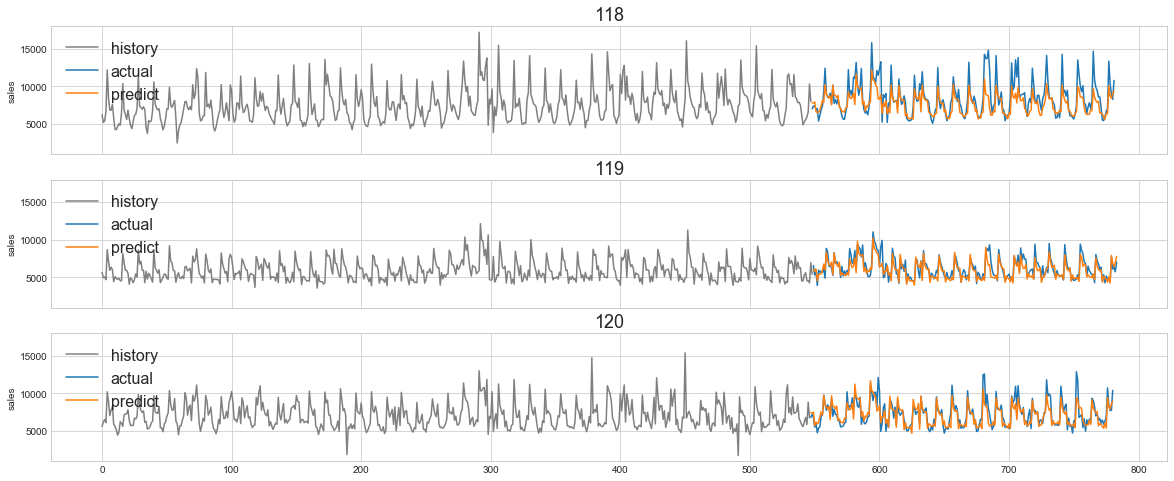

In [39]:
n_rows, n_cols = 3, 1
f, ax = plt.subplots(n_rows, n_cols, figsize=(20, 8), sharex=True, sharey=True)

for r, idx in enumerate(np.arange(pos, pos + n_rows)):
    samples = merge.query(f'store == {idx}').sort_values('date')
    hist = samples[samples.predict.isnull()]
    predict = samples[samples.predict.notnull()]
    ax[r].plot(np.arange(len(hist)), hist.sales.values, c='gray', label='history')
    ax[r].plot(np.arange(len(hist), len(hist) + len(predict)), predict.sales.values, label='actual')
    ax[r].plot(np.arange(len(hist), len(hist) + len(predict)), predict.predict.values, label='predict')
    ax[r].set_title(f'{idx}', size=18)
    ax[r].set_ylabel('sales')
    ax[r].set_ylabel('sales')
    ax[r].grid(True)
    ax[r].legend(loc='best', prop={'size': 16})
pos += n_rows
plt.show()

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
## Appendix

+ Use `tf.saved_model.loader.load`, only for `json_serving_input_fn `

In [ ]:
%%time
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

ctrl = Ctrl.instance
test_df = ctrl.transform(pd.Series({'fpath': './data/test.csv'}))
params = pd.Series({
    'datasource': test_df,
    'is_src_file': False
})
pred = ctrl.local_predict_alt(params)
print(pred)

## Tensor data inspection

In [3]:
from trainer import app_conf, metadata, input, service, model
from trainer.ctrl import Ctrl
"""
'sales_mean', 'promo2since', 'competition_distance', 'competition_open_since', 
'state_embedding', 'state_holiday_embedding', 'assortment_embedding', 
'store_type_embedding', 'competition_open_since_month_embedding', 
'competition_open_since_year_embedding', 'promo2since_week_embedding', 
'promo2since_year_embedding', 'year_embedding', 'month_embedding', 
'day_embedding', 'store_embedding', 'day_of_week_indicator', 
'open_indicator', 'promo_indicator', 'promo2_indicator', 'school_holiday_indicator'

'store', 'day_X_day_of_week_X_month_X_promo_X_promo2_X_year', 
'promo_X_promo2_X_school_holiday_X_state_holiday', 'assortment_X_day_of_week_X_state_X_store_type', 
'competition_open_since_month_X_competition_open_since_year'
"""
origin, encoded, all_ = Ctrl.instance.inspect('month', 'month_embedding', typ='deep')
print(all_.shape)
print(origin)
print(encoded)

2018-08-02 14:52:03,103 - trainer.input - INFO [line:457] - 
2018-08-02 14:52:03,104 - trainer.input - INFO [line:458] - * data input_fn:
2018-08-02 14:52:03,105 - trainer.input - INFO [line:459] - ================
2018-08-02 14:52:03,106 - trainer.input - INFO [line:460] - Mode: train
2018-08-02 14:52:03,107 - trainer.input - INFO [line:461] - Input file(s): D:\Python\notebook\ml_specialized\rossmann/data/processed/transformed/tr.csv
2018-08-02 14:52:03,108 - trainer.input - INFO [line:462] - Files encoding: csv
2018-08-02 14:52:03,109 - trainer.input - INFO [line:463] - Batch size: 5000
2018-08-02 14:52:03,110 - trainer.input - INFO [line:464] - Epoch count: 1
2018-08-02 14:52:03,112 - trainer.input - INFO [line:465] - Thread count: 8
2018-08-02 14:52:03,113 - trainer.input - INFO [line:466] - Shuffle: False
2018-08-02 14:52:03,113 - trainer.input - INFO [line:467] - ================
2018-08-02 14:52:03,114 - trainer.input - INFO [line:468] - 
2018-08-02 14:52:03,124 - trainer.input 

## Test

In [73]:
%%time
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

ctrl = Ctrl.instance
print( ctrl.test() )

2018-07-31 10:51:58,870 - trainer.input - INFO [line:412] - 
2018-07-31 10:51:58,871 - trainer.input - INFO [line:413] - * data input_fn:
2018-07-31 10:51:58,873 - trainer.input - INFO [line:414] - ================
2018-07-31 10:51:58,874 - trainer.input - INFO [line:415] - Mode: train
2018-07-31 10:51:58,875 - trainer.input - INFO [line:416] - Input file(s): D:\Python\notebook\ml_specialized\rossmann/data/processed/transformed/tr.csv
2018-07-31 10:51:58,876 - trainer.input - INFO [line:417] - Files encoding: csv
2018-07-31 10:51:58,877 - trainer.input - INFO [line:418] - Batch size: 5000
2018-07-31 10:51:58,878 - trainer.input - INFO [line:419] - Epoch count: 10
2018-07-31 10:51:58,879 - trainer.input - INFO [line:420] - Thread count: 8
2018-07-31 10:51:58,880 - trainer.input - INFO [line:421] - Shuffle: False
2018-07-31 10:51:58,880 - trainer.input - INFO [line:422] - ================
2018-07-31 10:51:58,881 - trainer.input - INFO [line:423] - 
2018-07-31 10:51:58,893 - trainer.input